# 3DFlex Flow Generator
## Introduction
This phython code is a realization of the flow generator reported in the paper: *3D Flexible Refinement: Structure and Motion of Flexible Proteins from Cryo-EM*.

The full papaer is retrievable through: https://www.biorxiv.org/content/10.1101/2021.04.22.440893v1

Packages required to run this python code: [`meshpy, numpy, matplotlib, mpl_toolkits`](#code)


## Tetrahedral Mesh in a Cube $[0,1]^3$

A unit cube with vertices $(0,0,0), (1,0,0), (1,1,0), (0,1,0), (0,0,1), (1,0,1), (1,1,1), (0,1,1)$ is meshed into tetrahedral elements. 

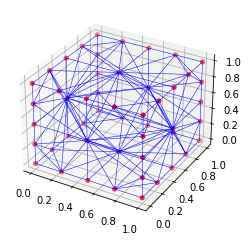

In [143]:
from meshpy.tet import MeshInfo, build
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

mesh_info = MeshInfo()

# create a mesh on a cube [0,1]^3 by specifying the eight vertex coordinates and the six facets.
mesh_info.set_points([
    (0,0,0), (1,0,0), (1,1,0), (0,1,0),
    (0,0,1), (1,0,1), (1,1,1), (0,1,1),
    ])
mesh_info.set_facets([
    [0,1,2,3],
    [4,5,6,7],
    [0,4,5,1],
    [1,5,6,2],
    [2,6,7,3],
    [3,7,4,0],
    ])
    
# max-volume sets the maximum volume of each small tetrahedron element.
mesh = build(mesh_info, max_volume = 0.1)

# mesh data can be output as a paraview readable file. Use code: 
# mesh.write_vtk("test.vtk")


E, P = np.array(mesh.elements), np.array(mesh.points)

# Option to print out the mesh points and elements. Use code: 
# print ("Mesh Points:")
# for i, p in enumerate(P):
#    print (i, p)
# print ("Point numbers in tetrahedra:")
# for i, t in enumerate(E):
#     print (i, t)

# Filter out the unique pairs of edges before drawing 
pairs1 = np.r_[E[:,[0,1]],E[:,[1,2]],E[:,[2,3]],E[:,[3,0]],E[:,[0,2]],E[:,[1,3]]]
for i, pair in enumerate(pairs1):
    if pair[0] > pair[1]:
        pairs1[i,0],pairs1[i,1] = pairs1[i,1], pairs1[i,0]
pairs2 = np.unique(pairs1, axis = 0)

# Form the line segments
segments = P[pairs2]

ax = plt.figure().add_subplot(projection='3d')
# draw the vertices of each tetrahedral elements
ax.scatter(P[:,0],P[:,1],P[:,2], color = 'r', linewidths = 0.5)
# draw the edges of all tetrahedral elements
ax.add_collection3d(Line3DCollection(segments, colors='b', linewidths=0.5, linestyles='-'))
    
plt.show()

## 3D Density Map: Torus as the Domain. 
The domain of the density map is a torus,
$$ \{(x,y,z)\in \mathbb R^3:(R-\sqrt{(x-x_0)^2+(y-y_0)^2})^2+(z-z_0)^2 = r^2\} $$

where $(x_0,y_0,z_0)$ is the center of the torus,\
$r$ is the radius of the tube,\
and $R$ is the radius of the disc.

The density maps $V(x,y,z)$
$$V:\mathbb R^3 \to \mathbb R$$
$$(x,y,z)\mapsto \frac 1d \sqrt{(x-x_0)^2+(y-y_0)^2+(z-z_0)^2}$$
where $d$ is a scaling factor such that the output distance is alwasy in $[0,1]$.

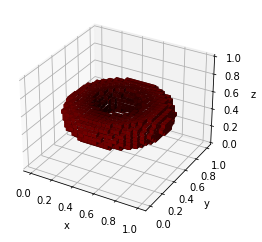

In [144]:
import numpy as np
import matplotlib.pyplot as plt

# find the midpoint coordinate of a 3D grid
def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# set 'N' so that the number of voxels in a cube [0,1]^3 will be N^3.
N = 25

# prepare the coordinates for each voxel
X, Y, Z = np.indices((N + 1, N + 1, N + 1)) / N
x = midpoints(X)
y = midpoints(Y)
z = midpoints(Z)

# define the torus domain centred at (0.5, 0.5, 0.5) with R and r
R = 0.3
r = 0.15
torus = (R - ((x -0.5) ** 2 + (y - 0.5) ** 2) ** (0.5)) ** 2 + (z - 0.5)**2 < r**2

# denfine the density function 3D
f = (2/3**(0.5))*((x - 0.5)**2 + (y - 0.5)**2 + (z - 0.5)**2)**(0.5)
V = np.multiply(f, torus.astype(int))

# assign density values to color scale in red
colors = np.zeros(torus.shape + (3,))
colors[..., 0] = V

# If other RGB color scale is desired, use code:
# colors[..., 1] = V
# colors[..., 2] = V

# plot the density map in the torus domain as voxel representation
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(X, Y, Z, torus,
          facecolors = colors,
          #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          edgecolors = 'k',
          linewidth = 0.5/N)
ax.set(xlabel='x', ylabel='y', zlabel='z')
plt.show()

## Define the Map from Canonical Coordinates to Deformed Coordinate
$$u:\mathbb R^3 \to \mathbb R^3$$
$$ \mathbf{x}\mapsto u(\mathbf{x})$$
$$u(\mathbf{x}) = \frac {5}{N\sqrt {(x-1.5)^2+(y-0.5)^2+(z-0.5)^2}}(1.5-x,0.5-y,0.5-z) + (x,y,z) $$
where $N^3$ is the number of voxels in a cube.

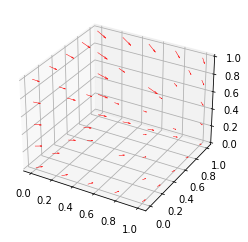

In [145]:
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import matplotlib.pyplot as plt

# initialize u(x) - x and u(x)
vectors = np.zeros(P.shape)
fvectors = np.zeros(P.shape)

vectors[:,0] = (5.0/N)*(1.5 - P[:,0])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)
vectors[:,1] = (5.0/N)*(0.5 - P[:,1])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)
vectors[:,2] = (5.0/N)*(0.5 - P[:,2])/((P[:,1] - 1.5)**2 + (P[:,2] - 0.5)**2 + (P[:,0] - 0.5)**2)**(0.5)

# define the flow vectors fields
fvectors = np.add(vectors, P)

# only draw the flow vector fields on the vertices of tetrahedron, that is to say, u(x) - x    
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(P[:,0],P[:,1],P[:,2], vectors[:,0], vectors[:,1], vectors[:,2], linewidth = 0.5, length = 0.3, color = 'red')

plt.show()

## Associate Each Voxel with the Correct Tetrahedron Element

The following linear transformation takes a point in cartesian coordinates and converts it into a point in tetrahedral coordinates where the tetrahedon has vertices $(x_i,y_i,z_i), i = 1,2,3,4$

The tetrahedral coordinates are defined such that $(x_1, y_1, z_1)$ is the origin while $(x_2 - x_1, y_2 - y_1, z_2 - z_1)$ is $x$-axis with unit length, $(x_3 - x_1, y_3 - y_1, z_3 - z_1)$ is $y$-axis with unit length and $(x_4 - x_1, y_4 - y_1, z_4 - z_1)$ is $z$-axis with unit length. For example, if the input of $\varphi$ is $(x_2, y_2, z_2)$, the output will be $(1, 0, 0)$.

\begin{equation*}
\varphi(\mathbf x) =
\begin{pmatrix}
x_2-x_1 & x_3-x_1 & x_4-x_1\\
y_2-y_1 & y_3-y_1 & y_4-y_1\\
z_2-z_1 & z_3-z_1 & z_4-z_1\\
\end{pmatrix}
^{-1}
\begin{pmatrix}
x-x_1\\
y-y_1\\
z-z_1\\
\end{pmatrix}

\end{equation*}

If a point $(x,y,z) $ is inside or on the tetrahedron, its tetrahedral coordinates $(x',y',z')=\varphi(x,y,z)$ must satisfy the following inequalities:
$$x' + y' + z' \le 1$$
$$0 \le x' \le 1$$
$$0 \le y' \le 1$$
$$0 \le z' \le 1$$

These inequalites are used to check whether an arbitary voxel is inside or on the tetrahedron element.

In [146]:
# import time if time complexity is run. 
# alternatively, import cupy as np if len(points)>1e7 and GPU
import numpy as np 

def Tetrahedron(vertices):
    """
    Given a list of the xyz coordinates of the vertices of a tetrahedron, 
    return tetrahedron coordinate system
    """
    origin, *rest = vertices
    mat = (np.array(rest) - origin).T
    tetra = np.linalg.inv(mat)
    return tetra, origin

def pointInside(point, tetra, origin):
    """
    Takes a single point or array of points, as well as tetra and origin objects returned by 
    the Tetrahedron function.
    Returns a boolean or boolean array indicating whether the point is inside the tetrahedron.
    """
    newp = np.matmul(tetra, (point-origin).T).T
    return np.all(newp>=0, axis=-1) & np.all(newp <=1, axis=-1) & (np.sum(newp, axis=-1) <=1)


voxels = np.array([np.reshape(x,(x.size,)), np.reshape(y,(y.size,)), np.reshape(z,(z.size,))]).T
indices = np.zeros((voxels.shape[0],1))

# this for loop can be improved for time consumption by swaping enumerate(voxels) and enumerate(E). The loops runs to delete the specific voxel once it is assignd to a tetrhadron. 

for i, points in enumerate(voxels):
    for j, vertices in enumerate(E):
        tetra, origin = Tetrahedron(P[vertices])
        inTet = pointInside(points, tetra, origin)
        if inTet == True:
            indices[i] = j        

#print(voxels)       


# test for time complexity
# npt=10000000
# points = np.random.rand(npt,3)
# # Coordinates of vertices A, B, C and D
# A=np.array([0.1, 0.1, 0.1])
# B=np.array([0.9, 0.2, 0.1])
# C=np.array([0.1, 0.9, 0.2])
# D=np.array([0.3, 0.3, 0.9])

# start_time = time.time()
# vertices = [A, B, C, D]
# tetra, origin = Tetrahedron(vertices)
# inTet = pointInside(points, tetra, origin)
# print("--- %s seconds ---" % (time.time() - start_time))


Test code to validate function [`Tetrahedron()`](#code) and [`pointInside()`](#code). Ingnorable. 

In [147]:
import numpy as np
tetra, origin = Tetrahedron(np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]]))
print(pointInside(np.array([1,1,1]),tetra,origin))
print(pointInside(np.array([0.1,0.1,0.1]),tetra,origin))

False
True


## Interpolating Flow Vector Fields at Each Voxel
Shape function for each tetrahedral element with vertices $(x_i, y_i, z_i), i = 1, 2, 3, 4$ and the corresponding flow vectors at each vertiex $(u_i, v_i, w_i)$ is defined as

$$
\phi : \mathbb R^3 \to \mathbb R^3
$$

$$
\mathbb x \mapsto
\phi(\mathbf x) = 
\begin{pmatrix}
u_1 & u_2 & u_3 & u_4 \\
v_1 & v_2 & v_3 & v_4 \\
w_1 & w_2 & w_3 & w_4  \\ 
\end{pmatrix}
\begin{pmatrix}
1 & 1 & 1 & 1 \\
x_1 & x_2 & x_3 & x_4 \\
y_1 & y_2 & y_3 & y_4  \\
z_1 & z_2 & z_3 & z_4 \\ 
\end{pmatrix}
^{-1}
\begin{pmatrix}
1 \\
x \\
y \\
z \\ 
\end{pmatrix}
$$

For each voxels inside or on the tetrahedral element, the shape function returns a linear combination of the four flow vectors at each vertex. This shape function can be easily written as an affine transformation. Denote 

$$
\phi(\mathbf x) 
=
\begin{pmatrix}
b_{1} & a_{11} & a_{12} & a_{13} \\
b_{2} & a_{21} & a_{22} & a_{23} \\
b_{3} & a_{31} & a_{32} & a_{33}  \\
\end{pmatrix}
\begin{pmatrix}
1 \\
x \\
y \\
z \\ 
\end{pmatrix} 
$$

Then, 

$$
\phi(\mathbf x) 
=
\begin{pmatrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23} \\
a_{31} & a_{32} & a_{33}  \\
\end{pmatrix}
\begin{pmatrix}
x \\
y \\
z \\ 
\end{pmatrix}
+ 
\begin{pmatrix}
b_1 \\
b_2 \\
b_3 \\ 
\end{pmatrix}
$$

that is to say,

$$\phi (\mathbf x) = A\mathbf x +\mathbf b$$ 
where $A$ is a $3\times 3$ matrix and $b$ is a column vector of dimension $3$. 

Notice that the flow vector field $u(\mathbf x)$ is exactly $\phi(\mathbf x)$ restricted to each tetrahedral element. Denote $u_{ij}(\mathbf x)$ as the flow vector field of the $i$-th image at $j$-th tetrahedral element, we have
$$u_{ij}(\mathbf x)=A_{ij}\mathbf x + \mathbf b_{ij}$$


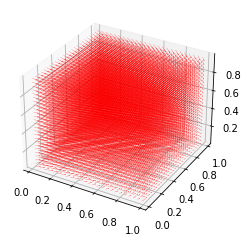

In [148]:
import numpy as np
import matplotlib.pyplot as plt

# assemble the shape function matrix where M[i] is the shape function of the i-th tetrahedron element
def shape_function(P, E, vectors):
    M = np.zeros((E.shape[0], 3, 4))
    
    for i, elements in enumerate(E):
        M[i] = np.matmul(vectors[elements].T, np.linalg.inv(np.c_[np.ones((4,1)),P[elements]].T))
    return M

# interpolating the flow vector at each voxel point.
def interpolation(voxels, indices, M):
    voxels_v = np.zeros(voxels.shape)
    coordinates = np.c_[np.ones((voxels.shape[0],1)),voxels]
    for i, points in enumerate(coordinates):
        voxels_v[i] = np.matmul(M[int(indices[i])], points.T)
    return voxels_v

# note that the interpolation is on u(x) and however we draw u(x) - x in the figure below.
M = shape_function(P, E, fvectors)
# u(x)
voxels_v0 = interpolation(voxels, indices, M)
# u(x)-x
voxels_v = np.subtract(voxels_v0, voxels)
# print(voxels_v)  

# draw the flow vector fields at each voxel
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(voxels[:,0], voxels[:,1], voxels[:,2], voxels_v[:,0], voxels_v[:,1], voxels_v[:,2], linewidth = 5/N, length=5/N, color = 'red')
plt.show()

## Define the Kernel Function
The kernel function acts as smoothing. A simple kernel is defined as follows:  

$$k:\mathbb R^3 \to \mathbb R$$
$$ \mathbf{x} \mapsto \left\{
\begin{array}{ll}
      1 & \max (|x|, |y|, |z|) < \frac{1}{2N} \\
      0.1 & \frac{1}{2N}\le\max (|x|, |y|, |z|)<\frac{2}{3N} \\
      0 & \text{otherwise}
\end{array} 
\right.$$ 

where $\frac 1N$ is the side length of each voxel

In [149]:
import numpy as np

# define the kernel function
def kernel(points, N):
    d = max(np.absolute(points)) 
    d_max = 1.0/(2.0*N)
    if d < d_max:
        return 1
    elif d >= d_max and d < 1.5*d_max:
        return 0.1
    else:
        return 0

## Calculate the Deformed Density Map
From the reference paper, the deformed desnity map is defined below. Intuitively, the deformed density at each voxel is the "average" of the convected density from the canonical model by the kernel smoothing. 
$$W:\mathbb R^3\to \mathbb R^3$$
$$\mathbf{x}\mapsto \sum_\mathbf{y} k(\mathbf{x}-u(\mathbf{y}))V(\mathbf y)$$

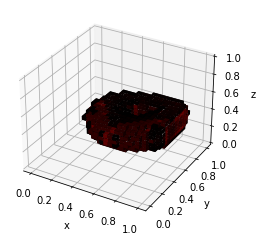

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Nvoxels = np.add(voxels, voxels_v)
Nvoxels = voxels_v0
V1 = np.reshape(V,(1,-1)).T
W = np.zeros(V1.shape)


# This loop definitely can be improved for time complexity!!!
for i, point in enumerate(voxels):
# Instead of searching for the entire list of Nvoxels, one can limit the search list to the surrounding points of i
    for j, Npoint in enumerate(Nvoxels):
        W[i] += kernel(np.subtract(point,Npoint),N)*V1[j]
# print(W)

# Normalize the density such that the density is always between [0,1]
W1 = np.divide(W,np.max(W))

colors = np.zeros(torus.shape + (3,))
colors[..., 0] = np.reshape(W1, (N, N, N))
# colors[..., 1] = V
# colors[..., 2] = V

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(X, Y, Z, colors[...,0] > 0,
          facecolors=colors,
          #edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          edgecolors = 'k',
          linewidth=0.5/N)
ax.set(xlabel='x', ylabel='y', zlabel='z')

plt.show() 

## Check rigidity of $u(\mathbf x)$
From the reference paper, the rigidity of $u(\mathbf x)_{ij}$ is defined as the sum of square deviation of singular values of $A_{ij}$ from unity. Denote 

$$u_{ij}(\mathbf x) = A_{ij}\mathbf x + b_{ij}$$

Assume the singular values of $A_{ij}$ are $s_{ij}^l, l = 1,2,3$ respectively. The the rigidity of $A_{ij}$ is defined as follows:
$$\sum_{l=1}^3 (s_{ij}^l-1)^2$$

In [151]:
import numpy.linalg as la

# return the rigidity of a 3 by 3 matrix
def rigidity(A):
    u, s, vh = la.svd(A)
    # return (s[0] - 1)**2 + (s[1] - 1)**2 + (s[2] - 1)**2
    return np.sum(np.square(s - np.ones(s.shape)))
    
# return the E_rigidity of a flow field u(x) with shape function M and weights w    
def E_rigidity(M, weights):
    N = M[:, :, 1:]
    E_r = 0
    for i, w in enumerate(weights):
        E_r += w*rigidity(N[i])
    return E_r 

Tests to validate function [`rigidity()`](#code) and [`E_rigidity()`](#code). Ignorable

In [152]:

import numpy as np

A = np.array([[1.1,0,0],[0,1.1,0],[0,0,1.1]])
print(rigidity(A))

B = np.array([[1.2,0,0],[0,1.2,0],[0,0,1.2]])
print(rigidity(B))

Test = np.array([np.c_[np.ones((3,1)),A], np.c_[np.ones((3,1)),B]])
print(E_rigidity(Test, np.array([1,1])))


0.030000000000000054
0.11999999999999994
0.15


Rigidity of the flow vector fields at $i$-th image is a weighted sum of rigidity of each tetrahedral elements. While the total rigidity of the flow vector fields is the summation of rigidity of all images. That is to say, the total rigidity $E_{rigidity}$ can be expressed as 
$$E_{rigidity} = \sum_i \sum_j w_j \sum_{l=1}^{3}(s_{ij}^l - 1)^2$$

In [153]:
import numpy as np
weights = np.ones(M.shape[0])
E_r = E_rigidity(M, weights)
print('Rigidity for the flow fields on current layer is')
print(E_r)
print('Average rigidity per singular value is')
print(E_r/(3*M.shape[0])) 

Rigidity for the flow fields on current layer is
9.962540651221085
Average rigidity per singular value is
0.048835983584417084
